In [38]:
import pandas as pd
import spacy
import stanza
import ast
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv('tokenization_after_segmentation.csv')
df.head()

,texts,sentences_stanza,sentences_spacy,num_sentences_stanza,num_sentences_spacy,unique_sent_stanza,unique_sent_spacy,tokens_stanza,tokens_spacy,tokens_occurence_stanza,tokens_occurence_spacy
0,Some notable French Huguenots or people with F...,['Some notable French Huguenots or people with...,['Some notable French Huguenots or people with...,1642,1630,"Jean Jacques Favre, pastor.","Antoine Barnave (1761-1783), French revolution...","['notable', 'french', 'huguenot', 'people', 'f...","['notable', 'french', 'huguenot', 'people', 'f...","Counter({'de': 290, 'pastor': 280, 'french': 2...","Counter({'de': 290, 'pastor': 280, 'french': 2..."
1,Abel Boyer (1667? – 16 November 1729) was a Fr...,['Abel Boyer (1667? – 16 November 1729) was a ...,['Abel Boyer (1667? – 16 November 1729) was a ...,54,51,Glen Buxton said he could listen to Barrett's ...,[The psychiatric evaluation of Jesus.,"['abel', 'boyer', 'november', 'french', 'engli...","['abel', 'boyer', 'november', 'french', 'engli...","Counter({'boyer': 27, 'french': 17, 'english':...","Counter({'boyer': 27, 'french': 17, 'english':..."
2,"Abolitionism, or the abolitionist movement, is...","['Abolitionism, or the abolitionist movement, ...","['Abolitionism, or the abolitionist movement, ...",332,302,"Francis Durand, convert from Roman Catholicism...","Faneuil hall and Faneuil Hall Market: or, Pete...","['abolitionism', 'abolitionist', 'movement', '...","['abolitionism', 'abolitionist', 'movement', '...","Counter({'slavery': 144, 'slave': 118, 'state'...","Counter({'slavery': 171, 'slave': 118, 'state'..."
3,"In the United States, abolitionism, the moveme...","['In the United States, abolitionism, the move...","['In the United States, abolitionism, the move...",545,518,"Renaud (1952-), pop-rock singer, anti-military...","Michael Pertwee (1916-1991), playwright and sc...","['united', 'state', 'abolitionism', 'movement'...","['united', 'state', 'abolitionism', 'movement'...","Counter({'slavery': 151, 'slave': 127, 'abolit...","Counter({'slavery': 207, 'slave': 127, 'abolit..."
4,Abraham Bosse (c. 1604 – 14 February 1676) was...,['Abraham Bosse (c.\u20091604 – 14 February 16...,['Abraham Bosse (c.\u20091604 – 14 February 16...,65,75,"Charles Chauvel (1897–1959), Australian film-m...","Ludwig Devrient (1784–1832), German actor.\n","['abraham', 'bosse', 'february', 'french', 'ar...","['abraham', 'bosse', 'february', 'french', 'ar...","Counter({'de': 34, 'la': 16, 'bosse': 14, 'le'...","Counter({'de': 34, 'la': 16, 'bosse': 14, 'le'..."


In [40]:
df['tokens_stanza'] = df['tokens_stanza'].apply(ast.literal_eval)
df['tokens_spacy'] = df['tokens_spacy'].apply(ast.literal_eval)

In [50]:
# creating vocabularies of unique tokens for each library
vocab_stanza = set(token for tokens in df['tokens_stanza'] for token in tokens)
vocab_spacy = set(token for tokens in df['tokens_spacy'] for token in tokens)

# tokens which simalteneously present in both vocabularies
SharedTokenInSentences = vocab_stanza.intersection(vocab_spacy)

# creating dataframe for storing pos tags
df_pos = pd.DataFrame(columns=['token', 'stanza_pos', 'spacy_pos'])
df_pos['token'] = list(SharedTokenInSentences)

In [ ]:
# pos tagging using stanza
nlp_stanza = stanza.Pipeline(lang='en', processors='tokenize,pos')
stanza_doc = df_pos['token'].apply(nlp_stanza)
df_pos['stanza_pos'] = [token.sentences[0].words[0].upos for token in stanza_doc]

In [78]:
# pos tagging using spacy
nlp_spacy = spacy.load('en_core_web_sm')
df_pos['spacy_pos'] = [t.pos_ for token in df_pos['token'].apply(nlp_spacy) for t in token]

In [79]:
df_pos.head()

,token,stanza_pos,spacy_pos
0,tower,NOUN,NOUN
1,word,NOUN,NOUN
2,hess,PROPN,NOUN
3,inoculated,VERB,VERB
4,lifeboat,NOUN,NOUN


In [81]:
print(f"Number of tokens in the dataset: {df_pos.shape[0]}")
print(f"Number of times the token is assigned the same UPOS by both libraries: {df_pos[df_pos['stanza_pos'] == df_pos['spacy_pos']].shape[0]}")
print(f"Ratio of the times the token is assigned the same UPOS by both libraries: {df_pos[df_pos['stanza_pos'] == df_pos['spacy_pos']].shape[0] / df_pos.shape[0]}")

Number of tokens in the dataset: 15349
Number of times the token is assigned the same UPOS by both libraries: 9666
Ratio of the times the token is assigned the same UPOS by both libraries: 0.6297478663105088


In [82]:
# list of pos tags in each library's results
upos_spacy = df_pos['spacy_pos'].unique()
upos_stanza = df_pos['stanza_pos'].unique()

In [100]:
def frequency_mapping(lib, upos_list):
    '''
    Map frequency of UPOS tags in one library to the other library
    lib: str, 'spacy' or 'stanza'
    upos_list: list of UPOS tags in the library
    '''
    if lib == 'spacy':
        other_lib = 'stanza'
    else:
        other_lib = 'spacy'

    print(f"Frequencies of {lib} UPOS tags")
    mapping = {}
    for tag in upos_list:
        print(f"\nFor all tokens labelled {tag} in {lib}:")

        mapping[tag] = {}
        sub_df = df_pos[df_pos[f'{lib}_pos'] == tag]
        other_lib_tag_list = df_pos[df_pos[f'{lib}_pos'] == tag][f'{other_lib}_pos'].unique()

        for other_tag in other_lib_tag_list:
            mapping[tag][other_tag] = len(sub_df[sub_df[f'{other_lib}_pos'] == other_tag]) / len(sub_df) * 100
        for key, value in mapping[tag].items():
            print(f"{key}: {value:.2f}%", end=", ")

    return mapping

In [107]:
mapping_spacy = frequency_mapping('spacy', upos_spacy)

Frequencies of spacy UPOS tags

For all tokens labelled NOUN in spacy:
NOUN: 63.20%, PROPN: 31.12%, ADJ: 2.60%, VERB: 2.05%, INTJ: 0.44%, X: 0.46%, SYM: 0.02%, ADV: 0.08%, NUM: 0.02%, PRON: 0.02%, 
For all tokens labelled VERB in spacy:
VERB: 53.57%, NOUN: 23.13%, ADJ: 5.64%, PROPN: 17.01%, X: 0.19%, AUX: 0.02%, INTJ: 0.37%, SYM: 0.02%, PUNCT: 0.02%, ADV: 0.02%, 
For all tokens labelled PROPN in spacy:
PROPN: 74.64%, X: 0.73%, ADJ: 3.14%, NOUN: 19.11%, INTJ: 1.32%, VERB: 0.88%, PRON: 0.04%, ADV: 0.11%, PUNCT: 0.04%, 
For all tokens labelled ADV in spacy:
ADV: 61.19%, NOUN: 8.21%, INTJ: 1.19%, PROPN: 18.81%, ADJ: 10.15%, CCONJ: 0.15%, SYM: 0.15%, VERB: 0.15%, 
For all tokens labelled ADJ in spacy:
ADJ: 73.24%, PROPN: 13.31%, NOUN: 10.90%, INTJ: 0.27%, VERB: 1.47%, ADV: 0.67%, X: 0.13%, 
For all tokens labelled ADP in spacy:
PROPN: 39.29%, NOUN: 10.71%, ADV: 30.36%, ADP: 14.29%, ADJ: 3.57%, INTJ: 1.79%, 
For all tokens labelled INTJ in spacy:
PROPN: 46.88%, ADJ: 3.12%, NOUN: 21.88%, INTJ

In [108]:
mapping_stanza = frequency_mapping('stanza', upos_stanza)

Frequencies of stanza UPOS tags

For all tokens labelled NOUN in stanza:
NOUN: 67.92%, VERB: 18.11%, PROPN: 9.50%, ADV: 1.00%, ADJ: 2.96%, ADP: 0.11%, X: 0.11%, INTJ: 0.13%, PRON: 0.05%, NUM: 0.02%, CCONJ: 0.04%, PUNCT: 0.05%, 
For all tokens labelled PROPN in stanza:
NOUN: 36.68%, PROPN: 40.71%, ADJ: 3.96%, ADP: 0.44%, INTJ: 0.30%, VERB: 14.60%, ADV: 2.51%, PUNCT: 0.14%, PRON: 0.12%, X: 0.36%, NUM: 0.02%, AUX: 0.12%, CCONJ: 0.04%, 
For all tokens labelled VERB in stanza:
VERB: 93.18%, NOUN: 4.88%, ADJ: 0.89%, PROPN: 0.97%, X: 0.04%, ADV: 0.04%, 
For all tokens labelled ADJ in stanza:
NOUN: 9.33%, PROPN: 5.21%, ADJ: 66.32%, VERB: 14.72%, ADV: 4.12%, X: 0.12%, INTJ: 0.06%, ADP: 0.12%, 
For all tokens labelled ADV in stanza:
ADV: 90.11%, NOUN: 1.10%, X: 0.22%, ADP: 3.74%, ADJ: 2.20%, AUX: 0.22%, SCONJ: 1.54%, PROPN: 0.66%, VERB: 0.22%, 
For all tokens labelled X in stanza:
PROPN: 34.48%, NOUN: 46.55%, VERB: 13.79%, ADJ: 3.45%, X: 1.72%, 
For all tokens labelled INTJ in stanza:
NOUN: 25.4

# Visualization

In [112]:
spacy2stanza = pd.DataFrame(mapping_spacy)
stanza2spacy = pd.DataFrame(mapping_stanza)

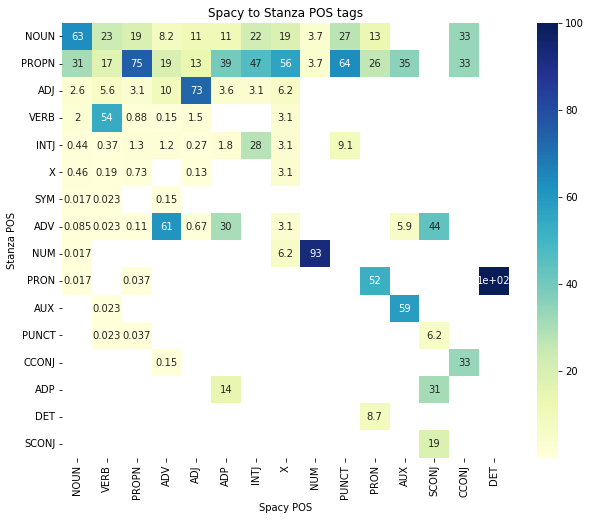

In [119]:
plt.figure(figsize=(10, 8))
sns.heatmap(spacy2stanza, annot=True, cmap='YlGnBu')
plt.title('Spacy to Stanza POS tags')
plt.xlabel('Spacy POS')
plt.ylabel('Stanza POS')
plt.show()

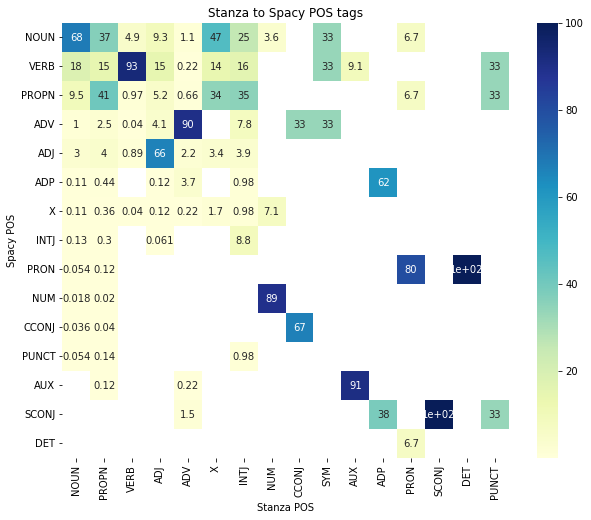

In [120]:
plt.figure(figsize=(10, 8))
sns.heatmap(stanza2spacy, annot=True, cmap='YlGnBu')
plt.title('Stanza to Spacy POS tags')
plt.xlabel('Stanza POS')
plt.ylabel('Spacy POS')
plt.show()